<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li></ul></li><li><span><a href="#вывод" data-toc-modified-id="вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
!pip install ydata-profiling

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor 
from catboost import CatBoostRegressor
from ydata_profiling import ProfileReport
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import cross_val_score, GridSearchCV , train_test_split, TimeSeriesSplit 
from sklearn.metrics import make_scorer, mean_squared_error 

In [3]:
data = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
profile = ProfileReport(data, title="Pandas Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Пропуск нет, а есть только 0,3% дубликат особо не влияет на данные


### Вывод

Исходный датасет состоит из следующих столбцов: • datetime — дата и время заказа такси • num_orders — количество заказов такси (целевой признак). Пропуски в данных отсутствуют.

Мы сделали предобработку данных и посмотрели на наши данные с количеством вызово за каждый час. Данные имеют большую частоту.

## Анализ

In [6]:
print('Starting date:',data.index.min())
print('Ending date:',data.index.max())
print('Total time:',data.index.max() - data.index.min())
print()
data.describe()

Starting date: 2018-03-01 00:00:00
Ending date: 2018-08-31 23:00:00
Total time: 183 days 23:00:00



,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


<AxesSubplot:xlabel='datetime'>

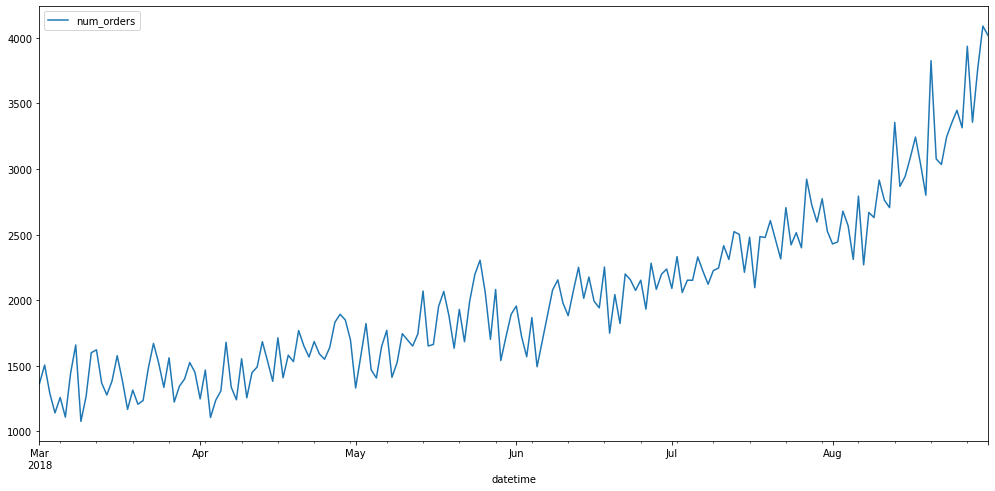

In [7]:
# Посмотрим на график вызовов по дням:
data.resample('1D').sum().plot(figsize=figsize) 

<AxesSubplot:xlabel='datetime'>

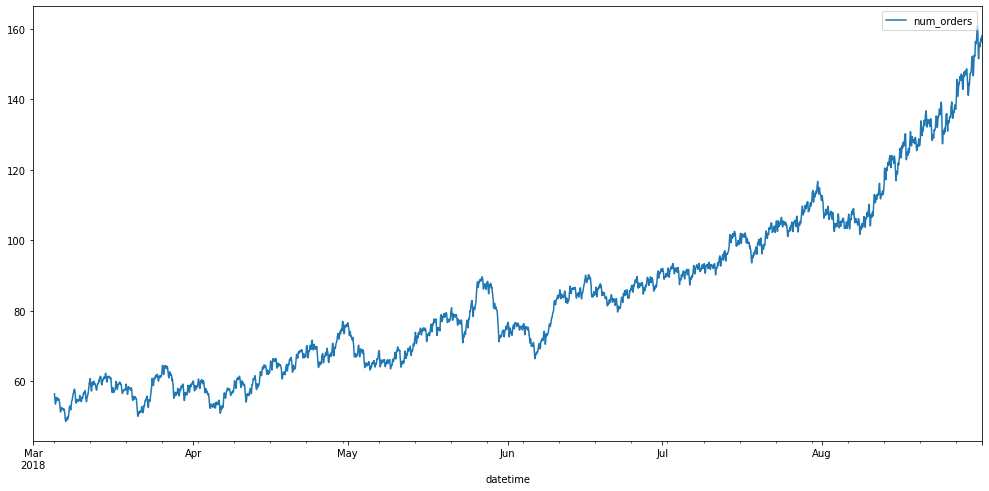

In [8]:
# Посмотрим на скользящую среднюю 100-ю:
data.rolling(100).mean().plot(figsize=figsize)

Данные имеют большие колебания, но с помощью средней скользящей мы уже видим восхдящий тренд сползающий вверх.



<AxesSubplot:xlabel='datetime'>

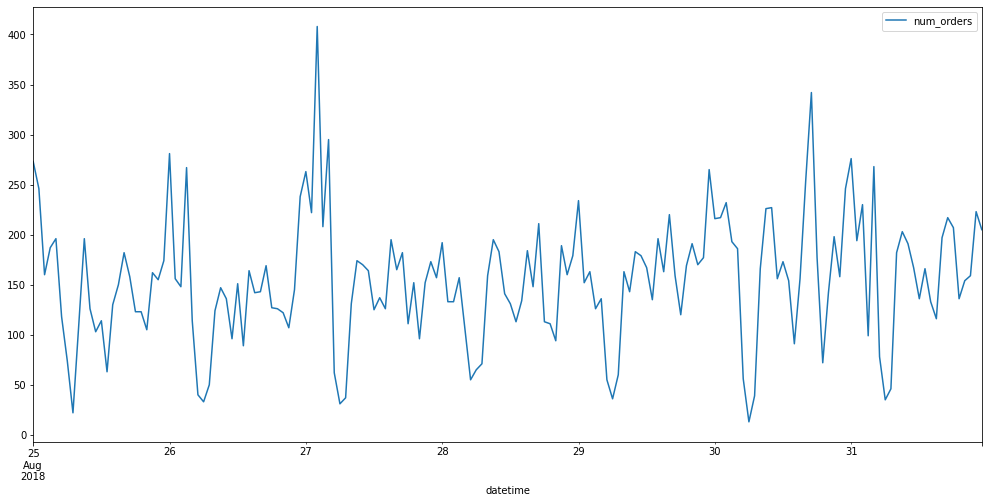

In [9]:
# Рассмотрим данные по последней неделе
data['2018-08-25':'2018-08-31'].plot(figsize=figsize)

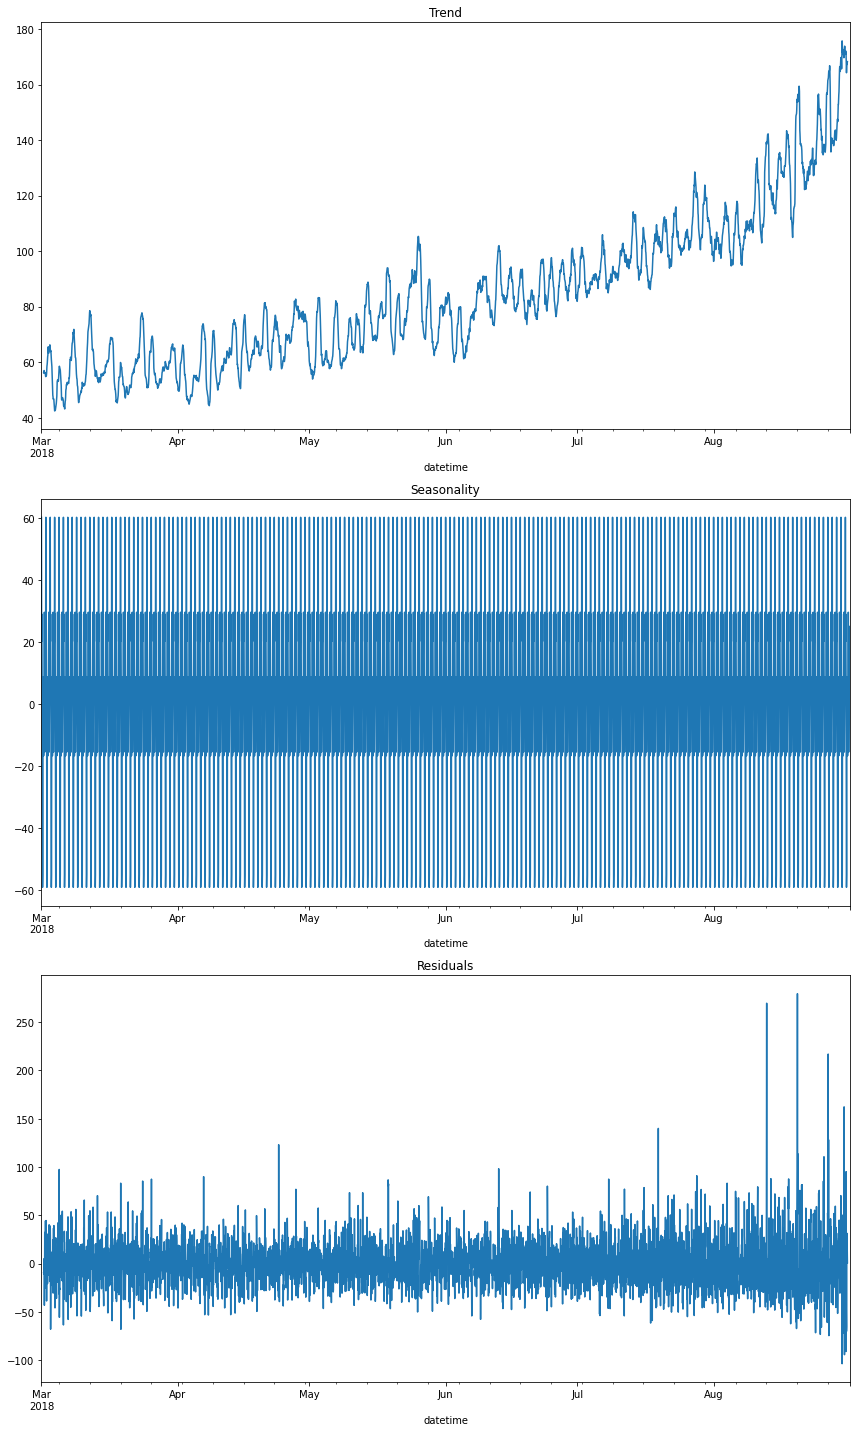

In [10]:
# Теперь проведем анализ временных рядов

decomposed = seasonal_decompose(data)

plt.figure(figsize=(12, 20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Графики показывают высокую частотность и суточную сезонность, уменьшим интервал и посмотрим за неделю:



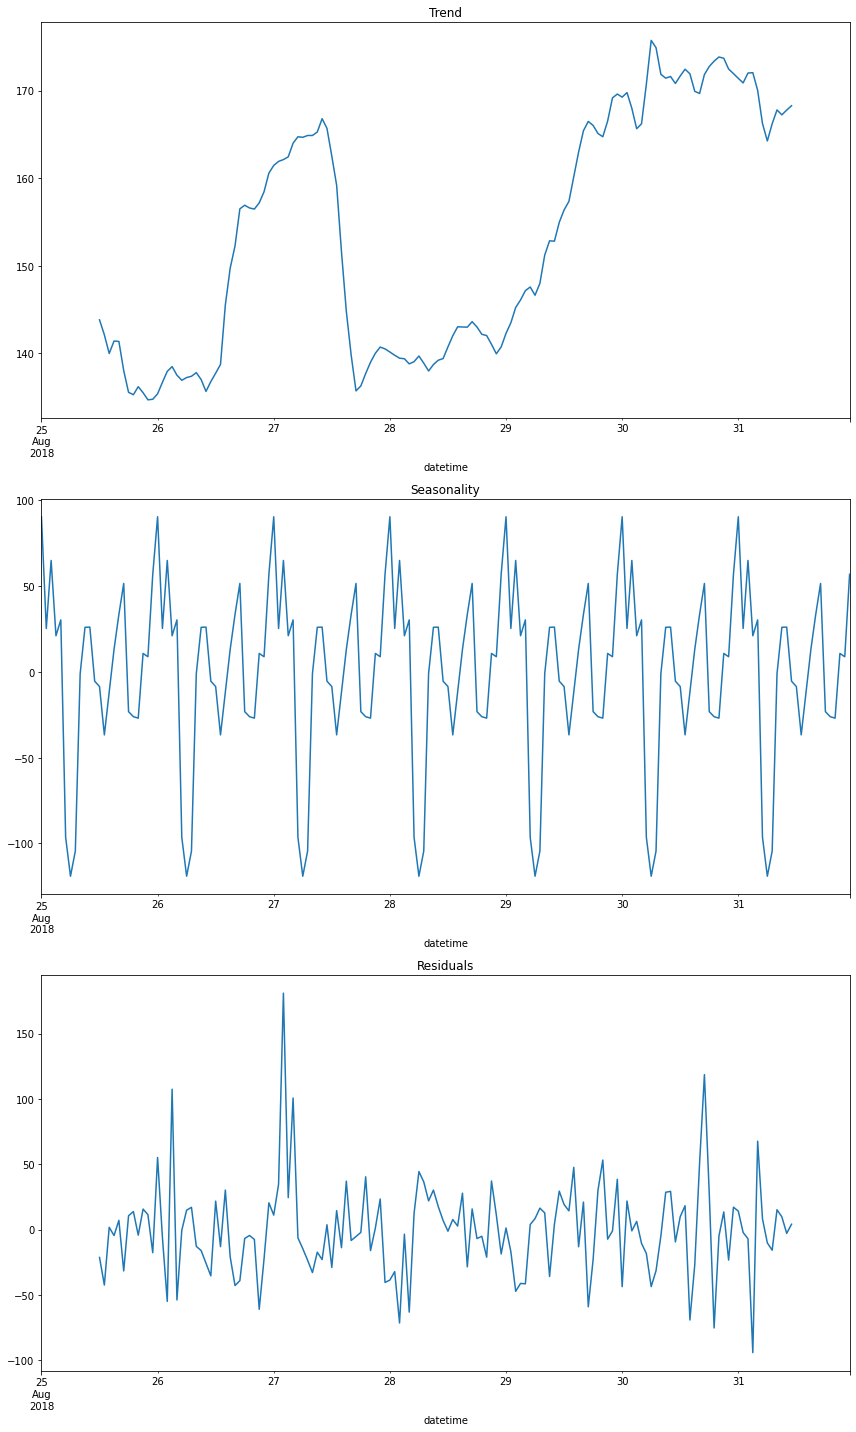

In [11]:
decomposed = seasonal_decompose(data['2018-08-25':'2018-08-31'])

plt.figure(figsize=(12, 20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()


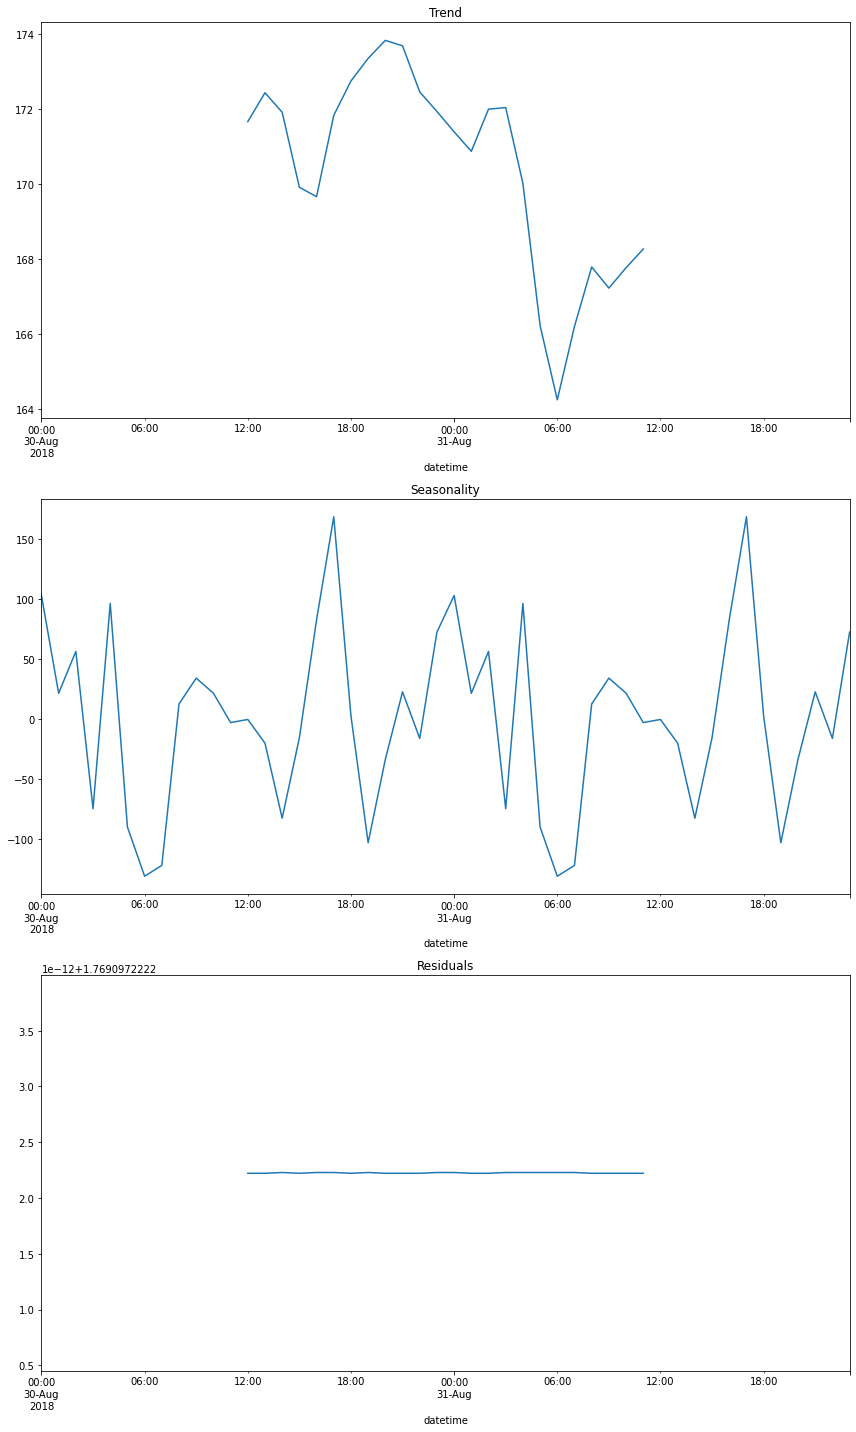

In [12]:
decomposed = seasonal_decompose(data['2018-08-30':'2018-08-31'])

plt.figure(figsize=(12, 20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()


Дисперсия ряда со временем увеличивается.
По тренду видно, что со временем все больше и больше людей пользуется услугой заказа такси.
И каждый день видно, что такси требуются для ночных рейсов и по наступлению утра намечается спад вызовов такси.

Временной ряд в таком виде не является стационарным, так как подвержен тренду, который меняется во времени.
Это можно подтвердить критерием Дики-Фуллера.

Нулевая гипотеза гласит: "Временной ряд является нестацинарным".
Альтернативная: "Временной ряд стационарен"

In [13]:
p_value = adfuller(data['num_orders'])[1]
print('P =', p_value)
if p_value < 0.05:
    print('Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера')
else:
    print('Нулевая гипотеза не отвергается. Ряд нестационарен по критерию Дики-Фуллера')

P = 0.028940051402612906
Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера


<AxesSubplot:xlabel='datetime'>

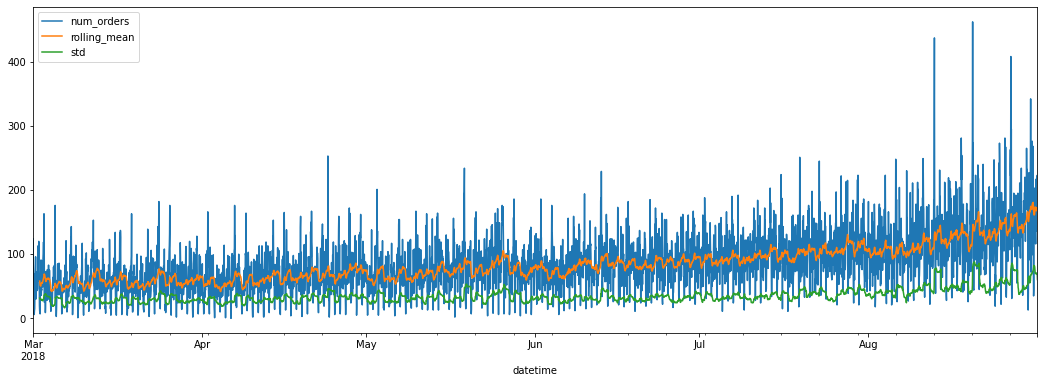

In [14]:
data_plot = data.copy()
data_plot['rolling_mean'] = data_plot.rolling(30).mean()
data_plot['std'] = data_plot['num_orders'].rolling(30).std()
data_plot.plot(figsize=(18, 6))

<AxesSubplot:xlabel='datetime'>

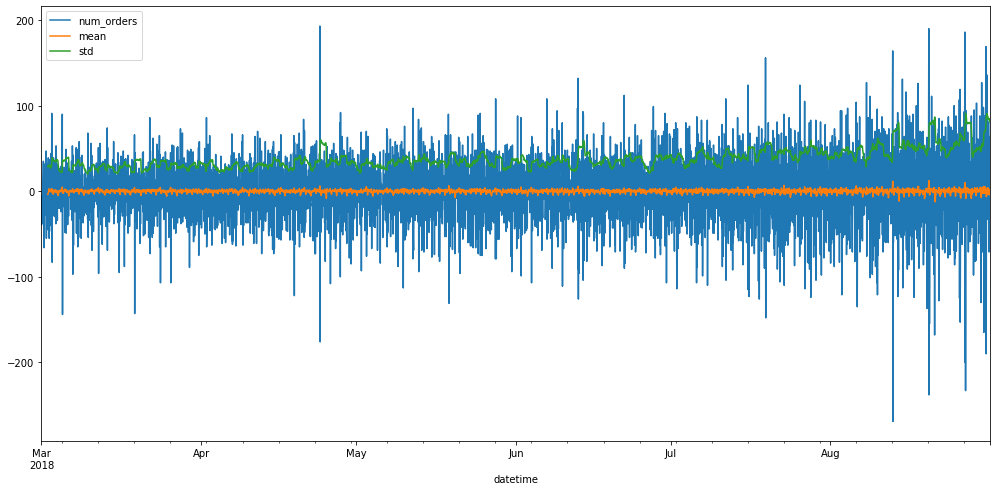

In [15]:
data_shift = data - data.shift()
data_shift['mean'] = data_shift['num_orders'].rolling(30).mean()
data_shift['std'] = data_shift['num_orders'].rolling(30).std()
data_shift.plot(figsize=figsize)

### Вывод

На этом этапе проведен анализ данных. Методом декомпозиции были выделены следующие аспекты:

*  время наблюдений наметился определенный тренд на общее увеличение заказов такси в течение часа, которое скорее всего вызвано ростом компании, поскольку есть гипотеза, что бизнес, связанный с такси не имеет месячной сезонности. Но данную гипотезу можно подтвердить или опровергнуть только имея данные за несколько лет.

* Дисперсия ряда со временем увеличивается.

* По тренду видно, что со временем все больше и больше людей пользуется услугой заказа такси.

* Каждый день видно, что такси требуются для ночных рейсов и по наступлению утра намечается спад вызовов такси.

## Обучение

Выберем следующие регрессоры для обучения модели:

1. LinearRegression
2. RandomForestRegressor
3. CatBoostRegressor


Пропишем функцию для создания признаков, а именно день недели, час -"отстающие значения", скользящее среднее:



In [16]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data = data.dropna()

In [17]:
# Применим функцию с лагом до 24 часов и 100-м скользящим средним
make_features(data, 24, 100)

In [18]:
# Удалим пропски и посмотрим данные:
data = data.dropna()
data.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-05 04:00:00,34,0,4,51.0,32.0,176.0,86.0,68.0,83.0,75.0,...,30.0,41.0,19.0,39.0,39.0,12.0,11.0,22.0,27.0,56.46
2018-03-05 05:00:00,16,0,5,34.0,51.0,32.0,176.0,86.0,68.0,83.0,...,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,22.0,55.56
2018-03-05 06:00:00,3,0,6,16.0,34.0,51.0,32.0,176.0,86.0,68.0,...,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,54.87
2018-03-05 07:00:00,14,0,7,3.0,16.0,34.0,51.0,32.0,176.0,86.0,...,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,54.19
2018-03-05 08:00:00,31,0,8,14.0,3.0,16.0,34.0,51.0,32.0,176.0,...,64.0,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,53.67


In [19]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [20]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(3884, 27)
(432, 27)
(3884,)
(432,)


Пропишу функцию для расчета метрики RMSE:



In [21]:
def RMSE(target, predict):
    return (mean_squared_error(target, predict))**0.5
   
#С помощию функции make_scorer создаю метрику RMSE
RMSE_score = make_scorer(RMSE, greater_is_better=False)

### LinearRegression

В связи с тем, что мы работаем с временным рядом, нельзя применять кросс-валидацию в привычном виде для подбора гиперпараметров моделей с помощью GridSearchCV. Поэтому применим функцию TimeSeriesSplit().



In [22]:
%%time

my_cv = TimeSeriesSplit(n_splits=8)
#Объявляю модель
regression = LinearRegression()
#Определяю RMSE модели с помощью кросс-валидации
regression_cv_score = pd.Series(cross_val_score(regression,features_train,target_train,scoring=RMSE_score,cv=my_cv)).mean()*(-1)

print(f'''Значение метрики RMSE на обучающей выборке для LinearRegression''', regression_cv_score)

Значение метрики RMSE на обучающей выборке для LinearRegression 26.861770596628958
CPU times: user 355 ms, sys: 607 ms, total: 962 ms
Wall time: 965 ms


### RandomForestRegressor

In [23]:
%%time

my_cv = TimeSeriesSplit(n_splits=3).split(features_train)
#Объявляю модель
forest = RandomForestRegressor()
#Определяю словарь с набором параметров
forest_parametrs = { 'n_estimators': range(5, 30, 5),
                     'max_depth': range(1, 15, 2),
                     'min_samples_leaf': range(1,5),
                     'min_samples_split': range(2,8,2) }

#Применяю GridSearchCV с кросс-валидацией
forest_grid = GridSearchCV(forest, forest_parametrs, scoring=RMSE_score, cv=my_cv)
forest_grid.fit(features_train, target_train)


CPU times: user 4min 11s, sys: 1.14 s, total: 4min 12s
Wall time: 4min 12s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f870bc34f20>,
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 15, 2),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 8, 2),
                         'n_estimators': range(5, 30, 5)},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [24]:
%%time

forest_params = forest_grid.best_params_
forest_score = forest_grid.score(features_train, target_train) * (-1)
print(forest_params)
print(f'''Значение метрики RMSE на обучающей выборке для RandomForestRegressor''',forest_score)
print('_______________')


{'max_depth': 13, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 20}
Значение метрики RMSE на обучающей выборке для RandomForestRegressor 13.823899199503648
_______________
CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 29.4 ms


### CatBoostRegressor

In [25]:
%%time

my_cv = TimeSeriesSplit(n_splits=3).split(features_train)
#Объявляю модель
cb = CatBoostRegressor()
#Определяю словарь с набором параметров
cb_parametrs = {'learning_rate': [0.03, 0.1],
                'depth': [4, 6, 10]
               }

#Применяю GridSearchCV с кросс-валидацией
cb_grid = GridSearchCV(cb, cb_parametrs, scoring=RMSE_score, cv=my_cv)
cb_grid.fit(features_train, target_train, verbose=100)

0:	learn: 28.8427470	total: 48.7ms	remaining: 48.6s
100:	learn: 17.8692599	total: 202ms	remaining: 1.79s
200:	learn: 15.9607824	total: 357ms	remaining: 1.42s
300:	learn: 14.7128169	total: 507ms	remaining: 1.18s
400:	learn: 13.5776480	total: 660ms	remaining: 986ms
500:	learn: 12.6540101	total: 821ms	remaining: 817ms
600:	learn: 11.7146676	total: 970ms	remaining: 644ms
700:	learn: 10.9266052	total: 1.12s	remaining: 479ms
800:	learn: 10.2835647	total: 1.27s	remaining: 317ms
900:	learn: 9.6413875	total: 1.43s	remaining: 157ms
999:	learn: 9.0798153	total: 1.58s	remaining: 0us
0:	learn: 31.8817805	total: 3.87ms	remaining: 3.87s
100:	learn: 20.1994746	total: 228ms	remaining: 2.03s
200:	learn: 18.5270027	total: 438ms	remaining: 1.74s
300:	learn: 17.4868682	total: 669ms	remaining: 1.55s
400:	learn: 16.5724681	total: 869ms	remaining: 1.3s
500:	learn: 15.8557860	total: 1.07s	remaining: 1.06s
600:	learn: 15.2104647	total: 1.26s	remaining: 835ms
700:	learn: 14.6605748	total: 1.45s	remaining: 619ms


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f870a3f0ba0>,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f870bbd9c40>,
             param_grid={'depth': [4, 6, 10], 'learning_rate': [0.03, 0.1]},
             scoring=make_scorer(RMSE, greater_is_better=False))

Определяем оптимальные гиперпараметры и качество модели на кросс-валидации:



In [26]:
%%time

cb_params = cb_grid.best_params_
cb_score = cb_grid.score(features_train, target_train) * (-1)
print(cb_params)
print(f'''Значение метрики RMSE на обучающей выборке для RandomForestRegressor''', cb_score)
print('_______________')

{'depth': 4, 'learning_rate': 0.03}
Значение метрики RMSE на обучающей выборке для RandomForestRegressor 17.416309815339226
_______________
CPU times: user 5.97 ms, sys: 3.98 ms, total: 9.95 ms
Wall time: 7.81 ms


In [27]:
column=['RMSE на обучающей выборке']

comparison_tabl = pd.DataFrame(index=['RMSE на обучающей выборке'], columns=['LinearRegression','RandomForestRegressor','CatBoostRegressor'])
comparison_tabl['LinearRegression'] = regression_cv_score
comparison_tabl['RandomForestRegressor'] =  forest_score
comparison_tabl['CatBoostRegressor'] = cb_score

comparison_tabl.T.style.highlight_min(color='yellowgreen',subset=column).highlight_null(null_color='lightgrey').highlight_max(color='coral',subset=column)


,RMSE на обучающей выборке
LinearRegression,26.861771
RandomForestRegressor,13.823899
CatBoostRegressor,17.416310


### Вывод


RMSE на обучающей выборке всех себя показала модель **RandomForestRegressor**, а по скорость обучения модель **CatBoostRegressor** 2 раза быстрее. Пропускаем модель **CatBoostRegressor** на тесте.

## Тестирование

In [28]:
# Тест на адекватность модели
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]

print('RMSE для проверки модели на адекватность:', round(RMSE(target_test, pred_previous), 3))

RMSE для проверки модели на адекватность: 59.157


### CatBoostRegressor

In [29]:
%%time

#Обучаю модель на оптимальных гиперпараметрах
cb_model = CatBoostRegressor(learning_rate=cb_params['learning_rate'],
                                depth=cb_params['depth'])

cb_model.fit(features_train, target_train, verbose=100)
cb_model_predictions = cb_model.predict(features_test)

#Определяю метрику RMSE
cb_RMSE = round(RMSE(target_test, cb_model_predictions), 3)
print('RMSE модели CatBoostRegressor:', cb_RMSE)


0:	learn: 38.2170015	total: 2.93ms	remaining: 2.92s
100:	learn: 24.2674485	total: 262ms	remaining: 2.33s
200:	learn: 22.7692978	total: 591ms	remaining: 2.35s
300:	learn: 21.7085475	total: 848ms	remaining: 1.97s
400:	learn: 20.7832879	total: 1.1s	remaining: 1.65s
500:	learn: 19.9726626	total: 1.36s	remaining: 1.36s
600:	learn: 19.3182983	total: 1.62s	remaining: 1.08s
700:	learn: 18.7501925	total: 1.9s	remaining: 811ms
800:	learn: 18.2674206	total: 2.17s	remaining: 539ms
900:	learn: 17.8233171	total: 2.43s	remaining: 267ms
999:	learn: 17.4163098	total: 2.7s	remaining: 0us
RMSE модели CatBoostRegressor: 40.665
CPU times: user 2.8 s, sys: 84.3 ms, total: 2.88 s
Wall time: 3.65 s


Пропишем функцию для построения сравнительных графиков "целевой признак - предсказание модели":



In [30]:
def graphicaizer(predictions):
    model_data = pd.DataFrame({"target":target_test, "predict":predictions})
    model_data.plot(figsize=(18, 6))
    model_data['2018-08-22':'2018-08-24'].plot(figsize=(18, 6))

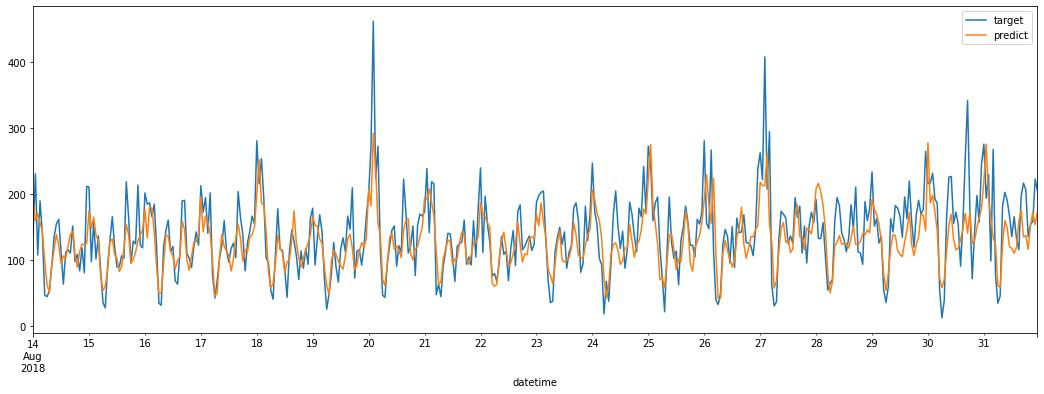

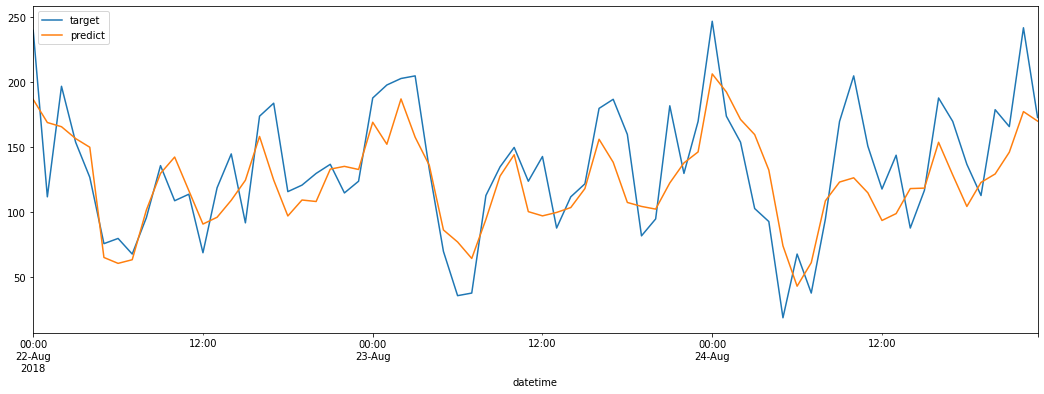

In [31]:
# Сравниваю наши данные и что мы предсказали по графику
graphicaizer(cb_model_predictions)

Объявляю функцию для построения графика важности признаков, она будет показывать только те признаки,важность которых больше 0.0:



In [32]:
def feature_importance_hist(model, features_train):
    importances = list(model.feature_importances_)
    names_indices = features_train.columns
    not_null_importances = []
    not_null_indices = []

    for i in importances:
        if i>0:
            not_null_importances.append(i)
            not_null_indices.append(names_indices[importances.index(i)])
    
    plt.figure(figsize=(15, 10))
    plt.title("Feature importances")
 
    plt.bar(range(len(not_null_importances)), not_null_importances, color="g")
    plt.xticks(range(len(importances)), not_null_indices, rotation=90)
 
    plt.tight_layout()
    plt.xlim([-1, len(not_null_importances)])
    plt.show()

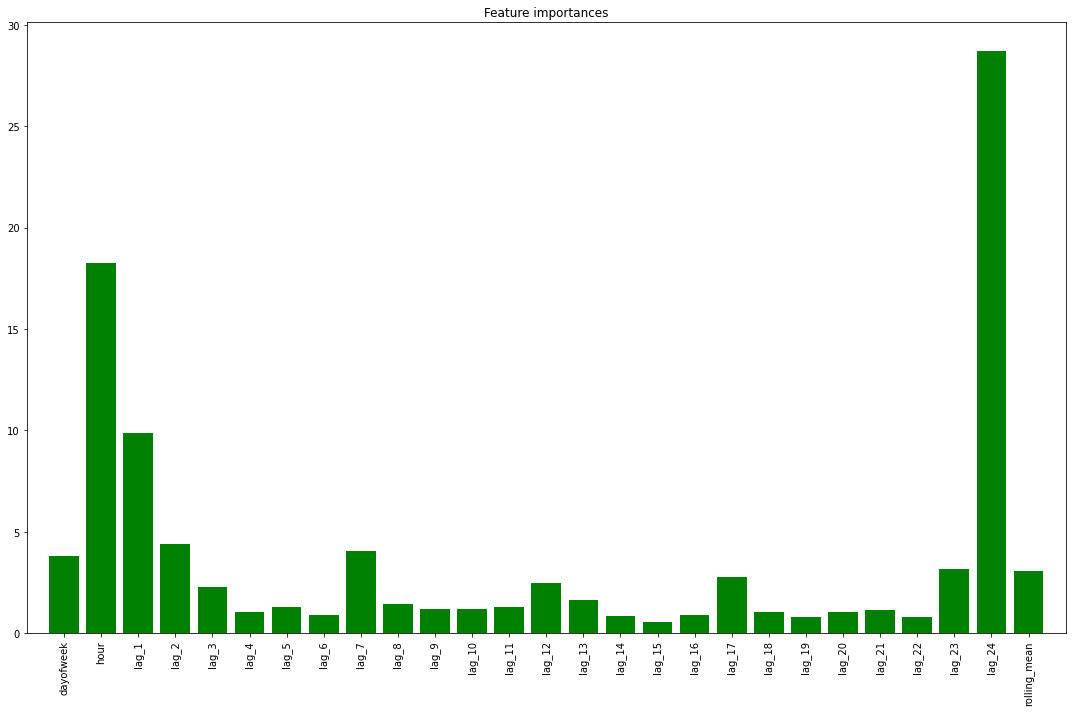

In [33]:
#Строю график важности признаков модели
feature_importance_hist(cb_model, features_train)

In [34]:
print('RMSE для проверки модели на адекватность:', round(RMSE(target_test, pred_previous), 3))
print('RMSE модели CatBoostRegressor:', cb_RMSE)

RMSE для проверки модели на адекватность: 59.157
RMSE модели CatBoostRegressor: 40.665


**Наилучший показатель RMSE в данном случае у CatBoostRegressor = 40,665.**


## вывод

При выполнении проекта проделана следующая работа:

* На первом этапе произведена загрузка данных и их подготовка для обучения моделей:

 * За время наблюдений наметился определенный тренд на общее увеличение заказов такси в течение часа, которое скорее всего вызвано ростом компании, поскольку есть гипотеза, что бизнес, связанный с такси не имеет месячной сезонности. Но данную гипотезу можно подтвердить или опровергнуть только имея данные за несколько лет.
 
* На третьем этапе к датасету были добавлены дополнительные признаки, а именно день недели, час "отстающие значения" и скользящее среднее. На дополнном датасете подобраны оптимальные гиперпараметры для моделей.

* На четвертом этапе проведено тестирование наилучший модель и  удалось достичь требуемого показателя метрики RMSE

* **Наилучший показатель RMSE в данном случае у CatBoostRegressor = 40,665.**
